In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import skimage as skimage
import scipy as scipy

import scipy.ndimage

import cv2 as cv

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
%config InlineBackend.figure_format ='retina'

plt.rcParams.update({'font.size': 25})

### Read Image

In [3]:
# from skimage.draw import circle_perimeter_aa

# raw_image = np.zeros((200, 200)).astype(np.float32)

# rr, cc, val = circle_perimeter_aa(100, 100, 80)
# raw_image[rr, cc] = val

# rr, cc, val = circle_perimeter_aa(100, 100, 30)
# raw_image[rr, cc] = val

# raw_image = raw_image * 255

# ########################################################################

# plt.imshow(raw_image, cmap = 'viridis', vmin = 0, vmax = 255)

# plt.colorbar()

# plt.tight_layout()

/Users/ajinkyakulkarni/anaconda3/lib/python3.9/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


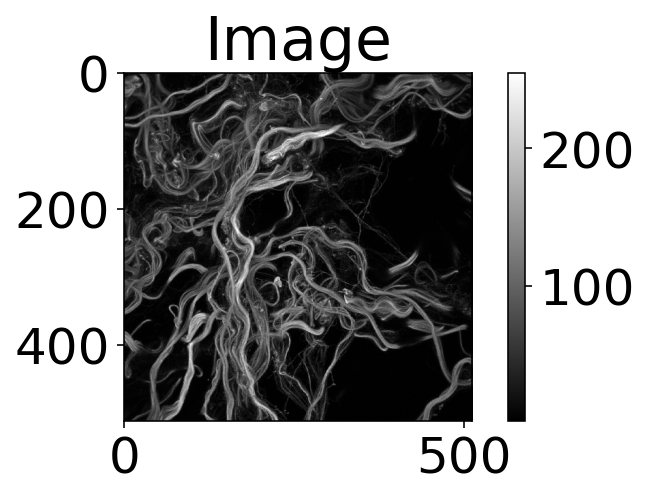

In [4]:
raw_image = skimage.io.imread('TestImage.tif', as_gray = True).astype('float32')

########################################################################

plt.imshow(raw_image, cmap = 'gray')

plt.title('Image')

plt.colorbar()

# plt.xticks([])

# plt.yticks([])

plt.tight_layout()

In [5]:
raw_image.shape

(512, 512)

### Create Image of same dimensions in X and Y

In [6]:
# raw_image = np.zeros((max(image.shape), max(image.shape)))

# raw_image[:len(image)] = image

In [7]:
# plt.imshow(raw_image, cmap = 'gray')

# plt.colorbar()

# # plt.xticks([])

# # plt.yticks([])

# plt.tight_layout()

### Create HeatMap

In [8]:
def make_HeatMap(input_image, heatmap_windows):

    # Define the local ROI
    
    local_region = skimage.morphology.rectangle(int(input_image.shape[0] / heatmap_windows), 
                                                int(input_image.shape[1] / heatmap_windows) )
    
    heatmap_image = skimage.filters.rank.mean(skimage.util.img_as_ubyte(input_image / input_image.max()), 
                                              footprint = local_region)
    
    return heatmap_image

### Make 2D Structure Tensor from Image

In [9]:
def make_StructureTensor2D(input_image, filter_sigma, window_size):

    ### Filter the image

    filtered_image = skimage.filters.gaussian(input_image, sigma = filter_sigma, mode = 'nearest')
    
    #########################################################################################################
    
    ### Calculate image gradients
    
    image_gradient_x = scipy.ndimage.sobel(filtered_image, axis = 0, mode = 'nearest')

    image_gradient_y = scipy.ndimage.sobel(filtered_image, axis = 1, mode = 'nearest')
    
    #########################################################################################################

    ### Calculate Jxx, Jyy and Jxy

    Jxx = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_x, window_size)

    Jyy = scipy.ndimage.gaussian_filter(image_gradient_y * image_gradient_y, window_size)

    Jxy = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_y, window_size)

    Jyx = Jxy

    #########################################################################################################
    
    ### Make Structure Tensor

    Raw_Structure_Tensor = np.array([[Jxx, Jxy], 
                                     [Jyx, Jyy]])

    Structure_Tensor = np.moveaxis(Raw_Structure_Tensor, [0, 1], [2, 3]) # For solving eigenproblem

    #########################################################################################################

    ### Solve EigenValue problem

    EigenValues, EigenVectors = np.linalg.eigh(Structure_Tensor)

    #########################################################################################################

    return Structure_Tensor, EigenValues, EigenVectors, Jxx, Jyy, Jxy

### Calculate Orientation vector field, Orientation and Coherance

In [10]:
def make_Coherance_Orientation(input_image, EigenValues, Structure_Tensor, Jxx, Jyy, Jxy):
    
    Coherance_Array = np.zeros(input_image.shape)
    
    vx = np.zeros(input_image.shape)
    
    vy = np.zeros(input_image.shape)

    ### Calculate Coherance and Orientation vector field

    Coherance_Array = np.zeros(input_image.shape)

    #############################################

    for j in range(input_image.shape[1]):

        for i in range(input_image.shape[0]):
            
            #############################################
            
            ### Calculate vector field of orientations

            vx[i, j] = EigenVectors[i, j][:, 0][0]

            vy[i, j] = EigenVectors[i, j][:, 0][1]

            #############################################
            
            ### Calculate Coherance

            if ( (EigenValues[i, j].sum()) > 0):

                Smallest_Normalized_Eigenvalues = EigenValues[i, j][0] / np.matrix.trace(Structure_Tensor[i, j])

                Largest_Normalized_Eigenvalues = EigenValues[i, j][1] / np.matrix.trace(Structure_Tensor[i, j])

                Coherance_Array[i, j] = np.abs((Smallest_Normalized_Eigenvalues - Largest_Normalized_Eigenvalues) /
                                               (Smallest_Normalized_Eigenvalues + Largest_Normalized_Eigenvalues))

            else:

                Coherance_Array[i, j] = 0

    # Normalize Coherance between 0 and 1

    Coherance = cv.normalize(Coherance_Array, None, alpha = 0, beta = 1, 
                             norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
    
    #############################################
    
    ### Calculate Orientation

    Raw_Orientation_Array = 0.5 * ( cv.phase( (Jyy - Jxx), (2 * Jxy), angleInDegrees = True) )

    #############################################
    
    # Normalize Orientation between 0 and 180

    Orientation = cv.normalize(Raw_Orientation_Array, None, alpha = 0, beta = 180, 
                               norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)

    return Coherance, Orientation, vx, vy

### Start the procedure

In [11]:
raw_image.shape

(512, 512)

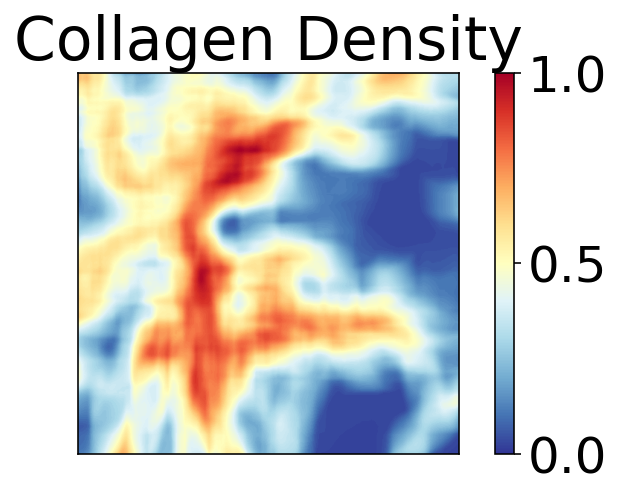

In [12]:
heatmap_averaging_windows = 10

heatmap_image = make_HeatMap(raw_image, heatmap_averaging_windows)

plt.imshow(heatmap_image / heatmap_image.max(), cmap = 'RdYlBu_r', vmin = 0, vmax = 1)

plt.colorbar()

plt.xticks([])

plt.yticks([])

plt.title('Collagen Density')

plt.tight_layout()

In [13]:
filter_image = 2

ROI_size = 10

# Make Structure_Tensor

Structure_Tensor, EigenValues, EigenVectors, Jxx, Jyy, Jxy = make_StructureTensor2D(raw_image, 
                                                                                    filter_image, 
                                                                                    ROI_size)

# Calculate Orientation, Coherance

Coherance, Orientation, vx, vy = make_Coherance_Orientation(raw_image, EigenValues, Structure_Tensor, Jxx, Jyy, Jxy)

### Plot Orientation and Coherance

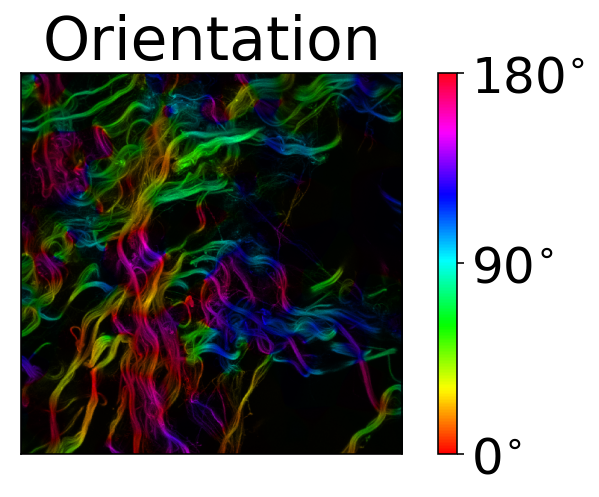

In [14]:
plt.imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Orientation/180), 
           vmin = 0, vmax = 1, cmap = 'hsv')

cbar = plt.colorbar(ticks = [0, 0.5, 1])
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'])
# cbar.ax.invert_yaxis()

plt.title('Orientation')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

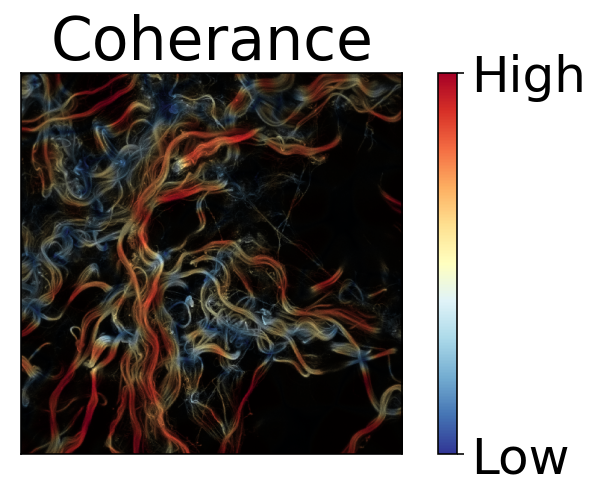

In [15]:
plt.imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.RdYlBu_r(Coherance), 
           vmin = 0, vmax = 1, cmap = 'RdYlBu_r')

cbar = plt.colorbar(ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])

plt.title('Coherance')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

### Plot everything together

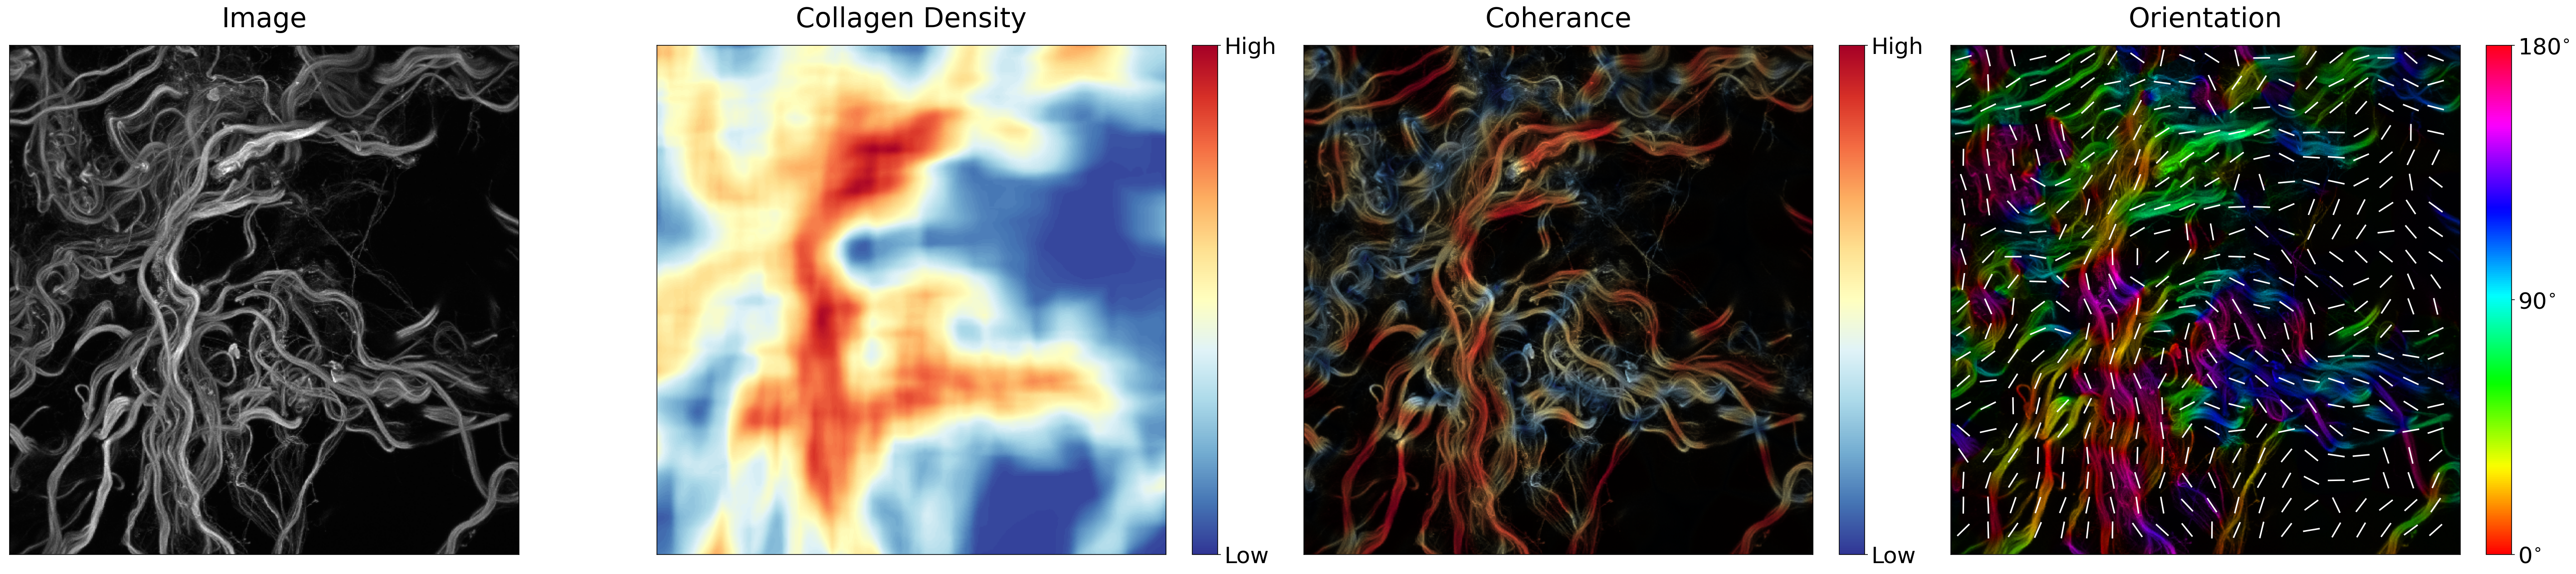

In [16]:
fig, ax = plt.subplots(1, 4, figsize = (40, 10), sharex = True, sharey = True)

ax[0].imshow(raw_image, cmap = 'binary_r', vmin = 0, vmax = 255)
ax[0].set_title('Image', pad = 20)
ax[0].set_xticks([])
ax[0].set_yticks([])
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.4)
cax0.remove()

########################################################################

im1 = ax[1].imshow(heatmap_image / heatmap_image.max(), cmap = 'RdYlBu_r', vmin = 0, vmax = 1)
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.4)

cbar = fig.colorbar(im1, cax=cax1, ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])

ax[1].set_title('Collagen Density', pad = 20)
ax[1].set_xticks([])
ax[1].set_yticks([])

########################################################################

im2 = ax[2].imshow(plt.cm.gray(raw_image / raw_image.max()) * plt.cm.RdYlBu_r(Coherance), 
                   vmin = 0, vmax = 1, cmap = 'RdYlBu_r')
divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.4)
cbar = fig.colorbar(im1, cax=cax2, ticks = [0, 1])
cbar.ax.set_yticklabels(['Low', 'High'])
ax[2].set_title('Coherance', pad = 20)
ax[2].set_xticks([])
ax[2].set_yticks([])

########################################################################

im3 = ax[3].imshow(plt.cm.gray(raw_image/raw_image.max()) * plt.cm.hsv(Orientation/180), 
                   vmin = 0, vmax = 1, cmap = 'hsv')
divider = make_axes_locatable(ax[3])
cax3 = divider.append_axes("right", size="5%", pad=0.4)

cbar = fig.colorbar(im3, cax=cax3, ticks = [0, 0.5, 1])
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'])

##################

s = 25

# s is the spacing between vectors. Lower s results in a denser vector plot

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

# scale is the length of the red lines. Less scale is more length

ax[3].quiver(ymesh[s//2::s, s//2::s], xmesh[s//2::s, s//2::s],
             vy[s//2::s, s//2::s], vx[s//2::s, s//2::s],
             scale = 30, 
             headlength = 0, headaxislength = 0, 
             pivot = 'middle',
             color = 'w', angles = 'xy')

##################

ax[3].set_title('Orientation', pad = 20)
ax[3].set_xticks([])
ax[3].set_yticks([])

########################################################################

fig.tight_layout()

plt.savefig('Analysis.pdf')